In [1450]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

In [1404]:
with open('dataframes/df2015', 'rb') as f_2015:
    df2015 = pickle.load(f_2015)
f_2015.close()

with open('dataframes/df2016', 'rb') as f_2016:
    df2016 = pickle.load(f_2016)
f_2016.close()

with open('dataframes/df2017', 'rb') as f_2017:
    df2017 = pickle.load(f_2017)
f_2017.close()

with open('dataframes/df2018', 'rb') as f_2018:
    df2018 = pickle.load(f_2018)
f_2018.close()

with open('dataframes/df2019', 'rb') as f_2019:
    df2019 = pickle.load(f_2019)
f_2019.close()

with open('dataframes/df2020', 'rb') as f_2020:
    df2020 = pickle.load(f_2020)
f_2020.close()

# Linear Regression
- The data in this set lends itself to linear regression since the happiness score is positively correlated with all its features as seen in the EDA steps. 
- GDP is the highest correlated features. 
- Since there are only 7 features, it's likely that we won't need to perform PCA on the dataset since there is no worthy feature to remove. These have all been engineered to be linearly correlated with our target (happiness). 
- Here, we will explore different ways regression can be applied to this dataset to make predictions.

### Question 1: What is the happines score of each country for 2020 given the 2020 features?
- we predicted for MOST countries based on SOME countries for this one

In [1405]:
Y = df2020['Score'] # target 
X = df2020.iloc[:, 1:].drop(['Score'],axis='columns') # features 
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=.2)
# print(train_x.shape)
# print(test_y.shape) # ok! 

In [1406]:
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x.iloc[:, 1:])
test_x = scaler.transform(test_x.iloc[:, 1:])

In [1407]:
lr_reg = LinearRegression()
lr_reg.fit(train_x, train_y) # keep the countries # index without it 
hyp = lr_reg.predict(test_x)

In [1408]:
# metrics
res = test_y - hyp
r2 = r2_score(test_y, hyp)
var = explained_variance_score(test_y, hyp)
mse = mean_squared_error(test_y, hyp)
print('R2 score...          \t', r2)
print('Variance explained...\t', var)
print('Mean squared error...\t', mse)

R2 score...          	 0.9660190101614696
Variance explained...	 0.9660526354173186
Mean squared error...	 0.03261915449038523


### Question 2: What is the happiness score of each country for 2020 given the the data from past years (2015-2019)?
- This is kind of a hot mess
- See how Ariana does this?

In [1409]:
Y = df_feats['Score'] # target 
X = df_feats.iloc[:, 1:].drop(['Score'],axis='columns') # features 
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=.2)
# print(train_x.shape)
# print(test_y.shape) # ok! 

In [1410]:
# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x.iloc[:, 1:])
# test_x = scaler.fit(test_x.iloc[:, 1:])

In [1411]:
# lr_reg = LinearRegression()
# lr_reg = GridSearchCV(lr, param_grid={}, n_jobs = 5)
# lr_reg.fit(train_x.iloc[:, 2:], train_y) # keep the countries # index without it 
# hyp = lr_reg.predict(test_x.iloc[:, 2:])

In [1412]:
# r2_score = r2_score(test_y, hyp)
# var = explained_variance_score(test_y, hyp)
# mse = mean_squared_error(test_y, hyp)
# print('R2 score...\t', r2_score)
# print('Variance explained...\t', var)
# print('Mean squared error...\t', mse)

### Question 3: Given that we predict the each feature for 2020, can we obtain a valid happiness score?
- We will predict the GDP for 2020 given 2015-2019, Health Life Expectancy for 2020 given 2015-2019, etc. 
- Once those features are predicted, we will predict the happiness score! 
### How to do it
- Start by generating features for 2019 (based on 2015-18)
- The 2019 data is used to test the output of the previous years
- We will create a set of features trained/tested by 2015-19
- At last, then we will use this model 

### Preliminary preprocessing
- Fill na
- Encode countries

In [1413]:
# put all features (2015-2019) together
df_all = pd.concat([df2015, df2016, df2017, df2018, df2019, df2020])
# df_all = pd.concat([df2015, df2016, df2017, df2018])
df_all[df_all['Perceptions of corruption'].isna()] # one null value 
mean = df_all[df_all['Country or region'] == 'United Arab Emirates']['Perceptions of corruption'].mean() # get avg 
df_all = df_all.fillna(mean) # fill na with mean

In [1414]:
# one hot encode countries
ohe = OneHotEncoder()
le = LabelEncoder()
le_country = le.fit_transform(df_all['Country or region'])
enc_country = pd.DataFrame(le_country, columns=['enc_country'])
ohe_country = ohe.fit_transform(enc_country[['enc_country']])
oh_enc_country = pd.DataFrame(ohe_country.toarray())

In [1415]:
df_all = df_all.join(oh_enc_country).reset_index()

In [1416]:
df2019 = df_all[df_all['year'] == 2019]
df2020 = df_all[df_all['year'] == 2020]

In [1417]:
# drop 2019 and 2020
df_all = df_all.drop(df_all[df_all['year'] == 2019].index)
df_all = df_all.drop(df_all[df_all['year'] == 2020].index)

In [1418]:
# reset indices # drop index columns
df_all = df_all.reset_index().drop(columns=['level_0', 'index'])
df2019 = df2019.reset_index().drop(columns=['level_0', 'index'])
df2020 = df2020.reset_index().drop(columns=['level_0', 'index'])

In [1419]:
df_all

,year,Country or region,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom,Perceptions of corruption,Generosity,...,128,129,130,131,132,133,134,135,136,137
0,2015,Switzerland,1,7.587,1.396510,1.349510,0.941430,0.665570,0.419780,0.296780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016,Denmark,1,7.526,1.441780,1.163740,0.795040,0.579410,0.444530,0.361710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017,Norway,1,7.537,1.616463,1.533524,0.796667,0.635423,0.315964,0.362012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018,Finland,1,7.632,1.305000,1.592000,0.874000,0.681000,0.393000,0.202000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,Iceland,2,7.561,1.302320,1.402230,0.947840,0.628770,0.141450,0.436300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,2016,Togo,155,3.303,0.281230,0.000000,0.248110,0.346780,0.115870,0.175170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
548,2018,Burundi,156,2.905,0.091000,0.627000,0.145000,0.065000,0.076000,0.149000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
549,2015,Burundi,157,2.905,0.015300,0.415870,0.223960,0.118500,0.100620,0.197270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550,2016,Burundi,157,2.905,0.068310,0.234420,0.157470,0.043200,0.094190,0.202900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1420]:
df2019

,year,Country or region,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom,Perceptions of corruption,Generosity,...,128,129,130,131,132,133,134,135,136,137
0,2019,Finland,1,7.769,1.340,1.587,0.986,0.596,0.393,0.153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019,Denmark,2,7.600,1.383,1.573,0.996,0.592,0.410,0.252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019,Norway,3,7.554,1.488,1.582,1.028,0.603,0.341,0.271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019,Iceland,4,7.494,1.380,1.624,1.026,0.591,0.118,0.354,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019,Netherlands,5,7.488,1.396,1.522,0.999,0.557,0.298,0.322,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2019,Malawi,150,3.410,0.191,0.560,0.495,0.443,0.089,0.218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,2019,Yemen,151,3.380,0.287,1.163,0.463,0.143,0.077,0.108,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,2019,Rwanda,152,3.334,0.359,0.711,0.614,0.555,0.411,0.217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,2019,Tanzania,153,3.231,0.476,0.885,0.499,0.417,0.147,0.276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1421]:
df2020

,year,Country or region,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom,Perceptions of corruption,Generosity,...,128,129,130,131,132,133,134,135,136,137
0,2020,Finland,1,7.8087,1.285190,1.499526,0.961271,0.662317,0.477857,0.159670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,Denmark,2,7.6456,1.326949,1.503449,0.979333,0.665040,0.495260,0.242793,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,Switzerland,3,7.5599,1.390774,1.472403,1.040533,0.628954,0.407946,0.269056,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020,Iceland,4,7.5045,1.326502,1.547567,1.000843,0.661981,0.144541,0.362330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020,Norway,5,7.4880,1.424207,1.495173,1.008072,0.670201,0.434101,0.287985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2020,Botswana,147,3.4789,0.997549,1.085695,0.494102,0.509089,0.101786,0.033407,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,2020,Tanzania,148,3.4762,0.457163,0.872675,0.442678,0.509343,0.203881,0.271541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,2020,Rwanda,150,3.3123,0.343243,0.522876,0.572383,0.604088,0.485542,0.235705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,2020,Zimbabwe,151,3.2992,0.425564,1.047835,0.375038,0.377405,0.080929,0.151349,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### GDP

In [1422]:
train_y = df_all['GDP per capita'].to_numpy()
train_x = df_all.iloc[:, 5:]
test_y = df2019['GDP per capita'].to_numpy()
test_x = df2019.iloc[:, 5:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [1423]:
test_x

array([[ 1.6258613 ,  1.67408632,  1.19170399, ..., -0.08543577,
        -0.08543577, -0.07392213],
       [ 1.58241379,  1.71741519,  1.16481244, ..., -0.08543577,
        -0.08543577, -0.07392213],
       [ 1.61034433,  1.85606757,  1.23876421, ..., -0.08543577,
        -0.08543577, -0.07392213],
       ...,
       [-1.09271149,  0.06225236,  0.91606556, ..., -0.08543577,
        -0.08543577, -0.07392213],
       [-0.552721  , -0.43602964, -0.01169307, ..., -0.08543577,
        -0.08543577, -0.07392213],
       [-1.69476984, -1.03396804, -2.81513762, ..., -0.08543577,
        -0.08543577, -0.07392213]])

In [1424]:
lr = LinearRegression()
lr.fit(train_x, train_y)
hyp_gdp = lr.predict(test_x)

In [1425]:
r2 = r2_score(test_y, hyp_gdp)
var = explained_variance_score(test_y, hyp_gdp)
mse = mean_squared_error(test_y, hyp_gdp)
print('R2 score...          \t', r2)
print('Variance explained...\t', var)
print('Mean squared error...\t', mse)

R2 score...          	 -1.1132784665707884e+24
Variance explained...	 -1.1052112313056834e+24
Mean squared error...	 1.589789589203305e+23


### Healthy Life Expectancy

In [1426]:
df2019.drop(columns=['Healthy life expectancy']).iloc[:, 4:]

,GDP per capita,Social support,Freedom,Perceptions of corruption,Generosity,0,1,2,3,4,...,128,129,130,131,132,133,134,135,136,137
0,1.340,1.587,0.596,0.393,0.153,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.383,1.573,0.592,0.410,0.252,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.488,1.582,0.603,0.341,0.271,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.380,1.624,0.591,0.118,0.354,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.396,1.522,0.557,0.298,0.322,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.191,0.560,0.443,0.089,0.218,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,0.287,1.163,0.143,0.077,0.108,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,0.359,0.711,0.555,0.411,0.217,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,0.476,0.885,0.417,0.147,0.276,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1427]:
train_y = df_all['Healthy life expectancy'].to_numpy()
train_x = df_all.drop(columns=['Healthy life expectancy']).iloc[:, 4:]
test_y = df2019['Healthy life expectancy'].to_numpy()
test_x = df2019.drop(columns=['Healthy life expectancy']).iloc[:, 4:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [1428]:
lr = LinearRegression()
lr.fit(train_x, train_y)
hyp_hle = lr.predict(test_x)

In [1429]:
r2 = r2_score(test_y, hyp_hle)
var = explained_variance_score(test_y, hyp_hle)
mse = mean_squared_error(test_y, hyp_hle)
print('R2 score...          \t', r2)
print('Variance explained...\t', var)
print('Mean squared error...\t', mse)

R2 score...          	 -2.5011035184523263e+24
Variance explained...	 -2.4829795799129963e+24
Mean squared error...	 1.200986471208112e+23


### Social support

In [1430]:
train_y = df_all['Social support'].to_numpy()
train_x = df_all.drop(columns=['Social support']).iloc[:, 4:]
test_y = df2019['Social support'].to_numpy()
test_x = df2019.drop(columns=['Social support']).iloc[:, 4:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [1431]:
lr = LinearRegression()
lr.fit(train_x, train_y)
hyp_ss = lr.predict(test_x)

In [1432]:
r2 = r2_score(test_y, hyp_ss)
var = explained_variance_score(test_y, hyp_ss)
mse = mean_squared_error(test_y, hyp_ss)
print('R2 score...          \t', r2)
print('Variance explained...\t', var)
print('Mean squared error...\t', mse)

R2 score...          	 0.07647775334872542
Variance explained...	 0.4056861057111397
Mean squared error...	 0.06989547116883021


### Freedom to make life choices

In [1433]:
train_y = df_all['Freedom'].to_numpy()
train_x = df_all.drop(columns=['Freedom']).iloc[:, 4:]
test_y = df2019['Freedom'].to_numpy()
test_x = df2019.drop(columns=['Freedom']).iloc[:, 4:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [1434]:
lr = LinearRegression()
lr.fit(train_x, train_y)
hyp_fre = lr.predict(test_x)

In [1435]:
r2 = r2_score(test_y, hyp_fre)
var = explained_variance_score(test_y, hyp_fre)
mse = mean_squared_error(test_y, hyp_fre)
print('R2 score...          \t', r2)
print('Variance explained...\t', var)
print('Mean squared error...\t', mse)

R2 score...          	 -3.4766349913066802e+25
Variance explained...	 -3.451441984123262e+25
Mean squared error...	 6.758432230635313e+23


### Perceptions of corruption

In [1436]:
train_y = df_all['Perceptions of corruption'].to_numpy()
train_x = df_all.drop(columns=['Perceptions of corruption']).iloc[:, 4:]
test_y = df2019['Perceptions of corruption'].to_numpy()
test_x = df2019.drop(columns=['Perceptions of corruption']).iloc[:, 4:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [1437]:
lr = LinearRegression()
lr.fit(train_x, train_y)
hyp_per = lr.predict(test_x)

In [1438]:
r2 = r2_score(test_y, hyp_per)
var = explained_variance_score(test_y, hyp_per)
mse = mean_squared_error(test_y, hyp_per)
print('R2 score...          \t', r2)
print('Variance explained...\t', var)
print('Mean squared error...\t', mse)

R2 score...          	 -1.1247009260883402e+25
Variance explained...	 -1.1165509193775523e+25
Mean squared error...	 1.0475435132809058e+23


### Generosity

In [1439]:
train_y = df_all['Generosity'].to_numpy()
train_x = df_all.drop(columns=['Generosity']).iloc[:, 4:]
test_y = df2019['Generosity'].to_numpy()
test_x = df2019.drop(columns=['Generosity']).iloc[:, 4:]
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [1440]:
lr = LinearRegression()
lr.fit(train_x, train_y)
hyp_gen = lr.predict(test_x)

In [1441]:
r2 = r2_score(test_y, hyp_gen)
var = explained_variance_score(test_y, hyp_gen)
mse = mean_squared_error(test_y, hyp_gen)
print('R2 score...          \t', r2)
print('Variance explained...\t', var)
print('Mean squared error...\t', mse)

R2 score...          	 -0.31450207469643177
Variance explained...	 -0.1436839718660412
Mean squared error...	 0.012179396523683673


### Score ? 

## Predicting happiness score/rank
- Basically what we were doing from step 1, but with a predicted dataset

In [1442]:
data={'GDP per capita':hyp_gdp, 'Social support': hyp_ss, 
     'Healthy life expectancy': hyp_hle, 'Freedom': hyp_fre, 
      'Perceptions of corruption': hyp_per, 'Generosity': hyp_gen}
df_hyp = pd.DataFrame(data=data) # dataframe of hypothesis # train_x 

In [1443]:
df2020.iloc[:, 4:10]

,GDP per capita,Social support,Healthy life expectancy,Freedom,Perceptions of corruption,Generosity
0,1.285190,1.499526,0.961271,0.662317,0.477857,0.159670
1,1.326949,1.503449,0.979333,0.665040,0.495260,0.242793
2,1.390774,1.472403,1.040533,0.628954,0.407946,0.269056
3,1.326502,1.547567,1.000843,0.661981,0.144541,0.362330
4,1.424207,1.495173,1.008072,0.670201,0.434101,0.287985
...,...,...,...,...,...,...
133,0.997549,1.085695,0.494102,0.509089,0.101786,0.033407
134,0.457163,0.872675,0.442678,0.509343,0.203881,0.271541
135,0.343243,0.522876,0.572383,0.604088,0.485542,0.235705
136,0.425564,1.047835,0.375038,0.377405,0.080929,0.151349


In [1444]:
train_x = scaler.fit_transform(df_hyp.to_numpy())
train_y = df2019['Score']
# train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=.2)
test_x = scaler.transform(df2020.iloc[:, 4:10])
test_y = df2020['Score'].to_numpy()

In [1445]:
lr = LinearRegression()
lr.fit(train_x, train_y)
hyp = lr.predict(test_x) # actual 2020 features 

In [1446]:
r2 = r2_score(test_y, hyp)
var = explained_variance_score(test_y, hyp)
mse = mean_squared_error(test_y, hyp)
print('R2 score...          \t', r2)
print('Variance explained...\t', var)
print('Mean squared error...\t', mse)

R2 score...          	 0.5654640761936507
Variance explained...	 0.6129436524083103
Mean squared error...	 0.5228233695281939


## Viewing Results

In [1456]:
df2020_res = pd.DataFrame(df2020['Country or region'])
df2020_res = df2020_res.join(df2020['Score'])
df2020_res = df2020_res.join(pd.DataFrame(hyp, columns=['Hypothetical Score']))
df2020_res = df2020_res.join(df2020['Overall rank'])
df2020_res = df2020_res.rename({'Country or region': 'name', 'Score': 'Actual Score', 'Overall rank': 'Actual Rank'}, axis='columns')
df2020_res

,name,Actual Score,Hypothetical Score,Actual Rank
0,Finland,7.8087,6.093086,1
1,Denmark,7.6456,6.340153,2
2,Switzerland,7.5599,6.655884,3
3,Iceland,7.5045,7.032471,4
4,Norway,7.4880,6.662285,5
...,...,...,...,...
133,Botswana,3.4789,4.720391,147
134,Tanzania,3.4762,4.000412,148
135,Rwanda,3.3123,3.133126,150
136,Zimbabwe,3.2992,4.070699,151


In [1457]:
# plot the happiness score of each country on this map
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres')) # read in world df

# rename some df2020 names to match world df 
for index in df2020.index:
    if df2020.loc[index,'Country or region']=='United States':
        df2020.loc[index,'Country or region'] = 'United States of America'
merge2020 = pd.merge(world, df2020_res, on='name', how='left')

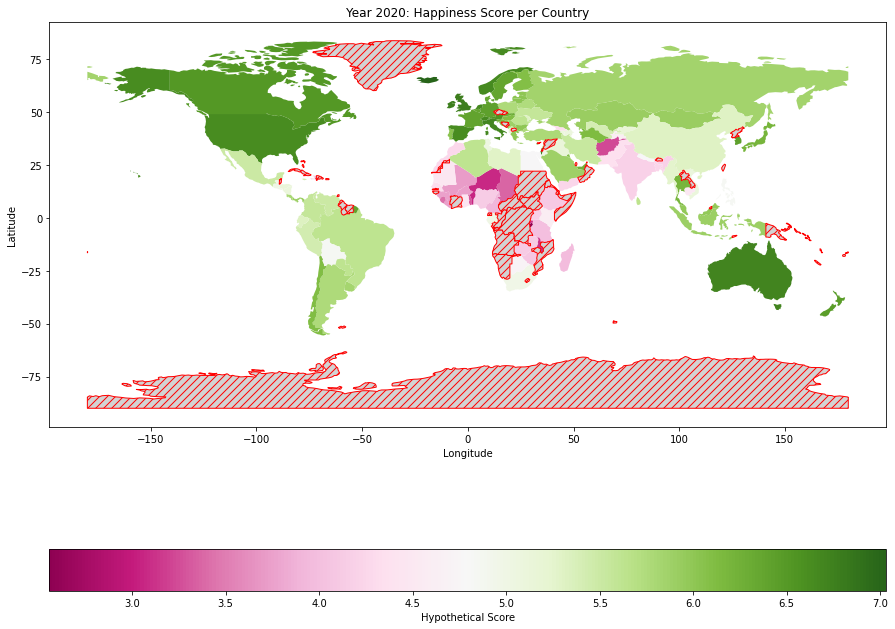

In [1459]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 15)
merge2020.plot(column='Hypothetical Score',legend=True, ax=ax,cmap='PiYG', legend_kwds={'label': "Hypothetical Score", 'orientation': "horizontal"},
missing_kwds={ "color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values", },)

plt.title('Year 2020: Happiness Score per Country', loc='center') # center title? 
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# References
- [Happiness Data Analysis 2015-2019](https://www.kaggle.com/kojisera/happiness-data-analysis-2015-2019) - See top happy 30 countries scatter plot for 2015-2019